In [1]:
# library containing all previously implemented optimization algorithms
# --> will be continously expanded within this course
include("optimization_library.jl");
include("mplstyle.jl");

# Exercise 3.2a
Implement the newton method.

In [2]:
# f: Objective function
# df: Gradient of the objective function
# Hf: Hessian of the objective function
# x0: Initial point
# ls: Use linesearch?
# ε: Stopping criterion on the newton decrement
# maxiters: Max number of iterations

function newton_descent(f, df, Hf, x0; ls=true, eps=0.000001, maxiters=1000)
    # make a copy of initial point to prevent changing x0 by manipulating x
    x = copy(x0)
    # store the trace of the descent path
    trace = [x; f(x)]
    
    for _=1:maxiters
        # ==========================================================
        # 1. evaluate the newton step d_nt (see Exercise 3.1)
        
        # hint for inverse divison operator in Julia: inv(A)*x  is equivalent to A \ x
        d = Hf(x) \ (-df(x))
        
        # 2. compute the newton decrement λ and break the loop if λ^2/2 < ϵ
        nwt_decrement2 = -df(x)'*d
        
        if 0.5*nwt_decrement2 < eps
            break
        end
        
        # 3. if (ls = true) reduce the step length by performing backtracking linesearch
        if ls
            d = linesearch(f, df, x, d) * d
        end
        
        # 4. update the point x
        x += d
        # ===========================================================        
        trace = hcat(trace, [x; f(x)])
    end
    return x,trace
end;

# Exercise 3.2b: Marathon Training Reviewed

<img src="figures/laufbahn.jpeg" width="350">

Remember the Marathon training from Exercise 2 where we found the optimal model for the given data by applying gradient descent. Now we want to compare with the result from the Newton Method.

We still assume a linear model with velocity $v$ scaling linearly with time $t$:
\begin{equation}
    m(t) = v t
\end{equation}

In [3]:
# Given Dataset

# times in minutes
t = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]

# distances in kilometers
d = [1.88, 4.47, 5.63, 8.13, 8.54, 11.23, 12.27, 14.23, 15.50, 16.93, 18.69, 21.31];

# linear model
function m(t, v)
    # The times are measured in minutes. We convert them in units of hours by dividing by 60. Like this, the velocity
    # has units of km/h
    return t .* (v/60)
end

m (generic function with 1 method)

In [4]:
# loss function
loss(v) = sum((d - m(t,v)).^2)

# Derivative of the loss function
function ∇loss(v)
    ∇inner = -t./60
    ∇outer = 2*(d - m(t, v))
    return ∇inner' * ∇outer
end


# ===============================================
# Define the Hessian of the loss function
H_loss(v) = 2*sum((t./60).^2)
# ===============================================

H_loss (generic function with 1 method)

In [5]:
x0 = 1

# Result from Gradient Descent
result_grd,trace_grd = gradient_descent(loss, ∇loss, x0, maxiters=10000, ϵ=0.0001, ls = true)
println("Optimal velocity [km/h]: ", result_grd)
println("Optimal loss: ", trace_grd[end,end])
println("Gradient at optimum: ", ∇loss(result_grd))
println("Iterations: ", size(trace_grd,2)-1)

Optimal velocity [km/h]: 10.524460831632599
Optimal loss: 3.7956961538551766
Gradient at optimum: -2.5524378370889167e-5
Iterations: 8


In [11]:
# Result of Newton Method
# ==========================================================
result_nwt, trace_nwt = newton_descent(loss, ∇loss, H_loss, x0; ls=true, eps=0.0001, maxiters=1000)
println("Optimal velocity [km/h]: ", result_nwt)
println("Optimal loss: ", trace_nwt[end,end])
println("Gradient at optimum: ", ∇loss(result_nwt))
println("Iterations: ", size(trace_nwt,2)-1)
# ==========================================================

Optimal velocity [km/h]: 10.524461538461539
Optimal loss: 3.795696153846153
Gradient at optimum: 2.9753977059954195e-14
Iterations: 1


In [7]:
# Test if the results from gradient descent and Newton method are the same
# ==========================================================
@assert result_nwt - result_grd < 0.0001
# ==========================================================

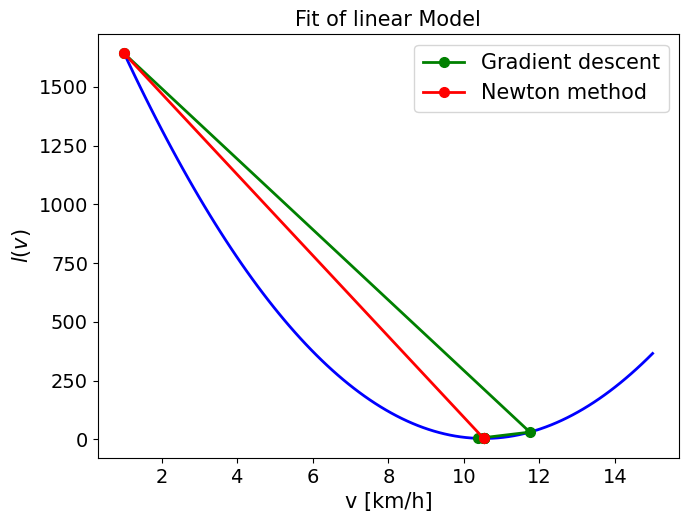

PyObject Text(0.5, 1.0, 'Fit of linear Model')

In [8]:
fontsize = 15
# plot the trace

# create values of velocities for which the loss function should be evaluated
test_velocities = range(1,15,length = 100)

# evaluate the loss function for some test velocities
losses = zeros(size(test_velocities,1))
for (index,test) in enumerate(test_velocities)
    losses[index] = loss(test)
end

plot(test_velocities',losses, color = "blue")
plot(trace_grd[1,:],trace_grd[2,:], marker = "o", color = "green", label = "Gradient descent")

# =============================================================================================
# add the trace of the Newton Method to the plot
plot(trace_nwt[1,:],trace_nwt[2,:], marker = "o", color = "red", label = "Newton method")
# =============================================================================================


xlabel("v [km/h]", fontsize=fontsize)
ylabel(L"$l(v)$", fontsize=fontsize)

#xlim(9,12)
#ylim(0,50)

legend(fontsize = fontsize)
title("Fit of linear Model", fontsize = fontsize)

# Exercise 3.2c

The linear model contains only one parameter that is estimated. However, the performance of gradient descent and Newton method differ most severely on high-dimensional problems, i.e. when the model contains a high number of parameters. Hence, we use the dataset from the marathon training an perform a fit of a higher-order polynomial (irrespectively if we know that this makes sense or not). We are interested to see how many iterations each method needs to reach the optimal combination of parameters $\theta_i$.

A polynomial of degree $d$ is given by:
\begin{equation}
P_d(\mathbf{t}) = \sum_{j = 0}^d \theta_j \mathbf{t}^j
\end{equation}
Note that $\mathbf{t}$ is a vector containing all measured times during the marathon training. In this case $\mathbf{t}^j$ is the vector resulting from evaluating the $j$-th power of each element in $\mathbf{t}$:
\begin{equation}
\mathbf{t}^j = (t_1^j, t_2^j, \dots, t_n^j)
\end{equation}

In [12]:
# generic implementation of a polynomial of arbitrary degree d
function model_poly(t, θ)
    # get the number of parameters. The polynomial degree d is given by d = n - 1
    n = size(θ,1)
    return ((t./60) .^ [0:n-1;]') * θ
end

# ===============================================================================
# implement the quadratic loss between the datapoints and model_poly(t,params)

loss_poly(θ) = sum((d .- model_poly(t, θ)).^2)

# ===============================================================================


# gradient of the loss function
function ∇loss_poly(θ)
    # get the number of parameter of the polynomial model
    n = size(θ,1)
    # ===============================================================================
    # Implement the gradient vector
    # Note that you always have to divide the measured times t by 60 in order to be consistent
    # with the rest of the notebook
    
    ∇outer = (2 .* (d .- model_poly(t, θ)))'
    ∇inner = (t./60) .^ [0:n-1;]'  # == ∇model
    
    ∇loss = ∇outer * ∇inner
    
    return - ∇loss'
    
    # ===============================================================================
end

# Hessian of the loss function
function H_loss_poly(θ)
    # get the number of parameter of the polynomial model
    n = size(θ,1)
    # ===============================================================================
    # Implement the hessian matrix
    # Note that you always have to divide the measured times t by 60 in order to be consistent
    # with the rest of the notebook
    
    ∇model = (t./60) .^ [0:n-1;]'
    return 2 .* (∇model' * ∇model)
    
    # ===============================================================================
    # get the number of parameter of the polynomial model

end

H_loss_poly (generic function with 1 method)

In [13]:
using Random
Random.seed!(42);
# define the number of paramaters in the polynomial model
n_θ = 2

# create an array of random numbers to get a starting point
θ_0 = 10*rand(n_θ)

# Result from Gradient Descent
# ===============================================================================
# uncomment the following lines
result_grd2, trace_grd2 = gradient_descent(loss_poly, ∇loss_poly, θ_0, maxiters=10000, ϵ=0.0001, p=0.5)
println("Minimizer: ", result_grd2)
println("Starting point: " ,(trace_grd2[1,1], trace_grd2[2,1]))
println("Optimal loss: ", trace_grd2[end,end])
println("Gradient at optimum: ",∇loss_poly(result_grd2))
println("Iterations: ", size(trace_grd2,2)-1)
# ===============================================================================

Minimizer: [0.7545559552625671, 9.981182511012893]
Starting point: (6.293451231426089, 4.503389405961936)
Optimal loss: 2.292641608711393
Gradient at optimum: [8.821263683778113e-5, 4.5512292340177396e-5]
Iterations: 107


In [17]:
# Result of Newton Method
# ==========================================================
result_nwt2, trace_nwt2 = newton_descent(loss_poly, ∇loss_poly, H_loss_poly, θ_0; ls=false, eps=0.0001, maxiters=1000)
println("Minimizer: ", result_nwt2)
println("Starting point: ", (trace_nwt2[1,1], trace_nwt2[2,1]))
println("Optimal loss: ", trace_nwt2[end,end])
println("Gradient at optimum: ", ∇loss_poly(result_nwt2))
println("Iterations: ", size(trace_nwt2,2)-1)
# ==========================================================

Minimizer: [0.7545454545454557, 9.98118881118881]
Starting point: (6.293451231426089, 4.503389405961936)
Optimal loss: 2.2926416083916132
Gradient at optimum: [-9.769962616701378e-15, -2.220446049250313e-14]
Iterations: 1


In [14]:
# Result of Newton Method
# ==========================================================
result_nwt2, trace_nwt2 = newton_descent(loss_poly, ∇loss_poly, H_loss_poly, θ_0; ls=true, eps=0.0001, maxiters=1000)
println("Minimizer: ", result_nwt2)
println("Starting point: ", (trace_nwt2[1,1], trace_nwt2[2,1]))
println("Optimal loss: ", trace_nwt2[end,end])
println("Gradient at optimum: ", ∇loss_poly(result_nwt2))
println("Iterations: ", size(trace_nwt2,2)-1)
# ==========================================================

Minimizer: [0.7545454545454557, 9.98118881118881]
Starting point: (6.293451231426089, 4.503389405961936)
Optimal loss: 2.2926416083916132
Gradient at optimum: [-9.769962616701378e-15, -2.220446049250313e-14]
Iterations: 1


In [15]:
# Test if the results from gradient descent and Newton method are the same
# ==========================================================
# uncomment the following line
@assert sum(result_nwt2 - result_grd2) < 0.0001
# ==========================================================

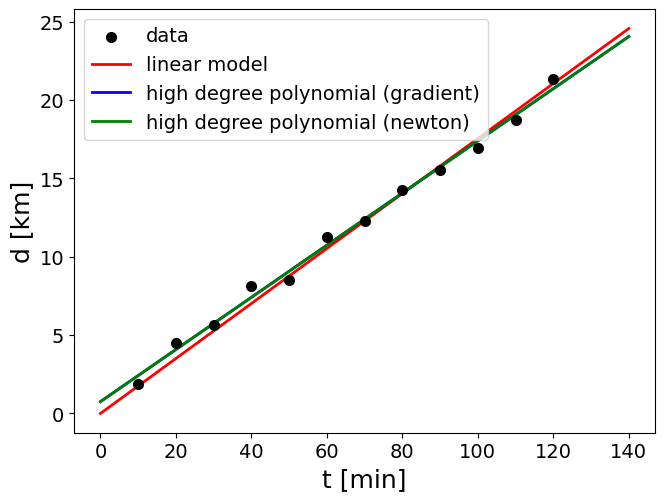

In [18]:
pygui(false)
# Plot linear and higher order polynomial models in order to compare to data points

# create more points for which the model can be plotted in order to get a smooth curve
times_plot = range(0, stop=140)
    
# plot data
scatter(t, d, color="black",zorder=3, label="data")

# plot models
plot(times_plot, m(times_plot, result_grd), color="red", label="linear model")

# plot the result of the newton method for high degree polynomial
plot(times_plot, model_poly(times_plot, result_grd2), color="blue", label="high degree polynomial (gradient)")

# ===============================================================================
# add the curve of the best fitting polynomial model evaluated by the newton method
plot(times_plot, model_poly(times_plot, result_nwt2)', color="green", label="high degree polynomial (newton)")
# ===============================================================================

xlabel("t [min]")
ylabel("d [km]")

legend(loc="upper left");

In [19]:
# plot the loss function for the case that the model is of degree 2, i.e. has 2 parameters

if n_θ == 2

    n_points = 50
    θ1_plot = range(minimum(trace_grd2[1,:])-0.1*minimum(trace_grd2[1,:]),maximum(trace_grd2[1,:])+0.1*maximum(trace_grd2[1,:]),length = n_points)
    θ2_plot = range(minimum(trace_grd2[2,:])-0.1*minimum(trace_grd2[2,:]),maximum(trace_grd2[2,:])+0.1*maximum(trace_grd2[2,:]),length = n_points)

    losses_plot = [loss_poly([θ1,θ2]) for θ1 = θ1_plot, θ2 = θ2_plot]

    # create grid points
    xgrid = repeat(θ1_plot',n_points,1)
    ygrid = repeat(θ2_plot,1,n_points)

    # allow window to open for interactions
    using3D()
    pygui(true);
    fig = figure("pyplot_surfaceplot",figsize=(15,10))
    ax = fig.add_subplot(1,1,1,projection="3d")

    # plot loss function
    plot_surface(xgrid', ygrid', losses_plot, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.3, linewidth=0.25)
    
    # plot traces of gradient and newton descent
    ax[:plot](trace_nwt2[1,:], trace_nwt2[2,:], trace_nwt2[3,:], color="red", zorder = 3)
    ax[:scatter](trace_nwt2[1,:], trace_nwt2[2,:], trace_nwt2[3,:], color="red")
    ax[:plot](trace_grd2[1,:], trace_grd2[2,:], trace_grd2[3,:], color="orange")
    ax[:scatter](trace_grd2[1,:], trace_grd2[2,:], trace_grd2[3,:], color="orange")
    
    xlabel(L"\theta_1", fontsize=fontsize)
    ylabel(L"\theta_2", fontsize=fontsize)
    zlabel(L"loss", fontsize=fontsize)
end

PyObject Text(0.09479538405482853, 0.012700173301844656, '$loss$')

In [20]:
# f: objective function
# ∇f: gradient of the objective function
# x0: initial point
# ε: stopping criterion on the norm of the gradient
# maxiters: max numbers of gradient descent steps

function gradient_descent_unchecked(f, ∇f, x0; ϵ=0.0001, maxiters = 1000, p = 0.5, lr=nothing)

    x = copy(x0)
    
    # store initial point and evaluated function at initial point 
    trace = [x; f(x)]
    for _=1:maxiters
        
        # ======================================================
        # 1. evaluate the descent step direction at the point x
        d = -∇f(x)
        # 2. check if norm of the gradient is close enough to zero (use precision of ϵ). If yes break from the
        #    loop.
        if LA.norm(d) < ϵ
            break
        end
        # 3. Evaluate the next point x by stepping into the descent direction.
        # Use the result of the backtracking linesearch to guarantee convergence.
        if lr === nothing
            d = linesearch(f, ∇f, x, d, p = p) * d
        else
            d = lr * d
        end
        x += d
        
        # ======================================================
        
        trace = hcat(trace,[x; f(x)])
        # @assert trace[end,end] <= trace[end,end-1]
    end
    return x,trace
end;

In [21]:
# Result from Overshooting Gradient Descent
# ===============================================================================
# uncomment the following lines
result_grd2_bad,trace_grd2_bad = gradient_descent_unchecked(loss_poly, ∇loss_poly, θ_0, maxiters=100, ϵ=0.0001, lr=0.02)
println("Minimizer: ",result_grd2_bad)
println("Optimal loss: ",trace_grd2_bad[end,end])
println("Gradient at optimum: ",∇loss_poly(result_grd2_bad))
println("Iterations: ", size(trace_grd2_bad,2))
# ===============================================================================

Minimizer: [0.760326337011217, 9.976599608805627]
Optimal loss: 2.292733125043796
Gradient at optimum: [0.019421917215497686, -0.01541825306073008]
Iterations: 101


In [23]:
# plot the loss function for the case that the model is of degree 2, i.e. has 2 parameters
#pygui(false)
if n_θ == 2

    n_points = 50
    θ1_plot = range(minimum(trace_grd2[1,:])-0.1*minimum(trace_grd2[1,:]),maximum(trace_grd2[1,:])+0.1*maximum(trace_grd2[1,:]),length = n_points)
    θ2_plot = range(minimum(trace_grd2[2,:])-0.1*minimum(trace_grd2[2,:]),maximum(trace_grd2[2,:])+0.1*maximum(trace_grd2[2,:]),length = n_points)

    losses_plot = [loss_poly([θ1,θ2]) for θ1 = θ1_plot, θ2 = θ2_plot]

    # create grid points
    xgrid = repeat(θ1_plot',n_points,1)
    ygrid = repeat(θ2_plot,1,n_points)

    # allow window to open for interactions
    using3D()
    pygui(true);
    fig = figure("pyplot_surfaceplot",figsize=(15,10))
    ax = fig.add_subplot(1,1,1,projection="3d")

    # plot loss function
    plot_surface(xgrid', ygrid', losses_plot, rstride=2,edgecolors="k", cstride=2, cmap=ColorMap("gray"), alpha=0.3, linewidth=0.25)
    
    # plot traces of gradient and newton descent
    ax[:plot](trace_nwt2[1,:], trace_nwt2[2,:], trace_nwt2[3,:], color="red", zorder = 3)
    ax[:scatter](trace_nwt2[1,:], trace_nwt2[2,:], trace_nwt2[3,:], color="red")
    ax[:plot](trace_grd2[1,:], trace_grd2[2,:], trace_grd2[3,:], color="orange")
    ax[:scatter](trace_grd2[1,:], trace_grd2[2,:], trace_grd2[3,:], color="orange")
    ax[:plot](trace_grd2_bad[1,:], trace_grd2_bad[2,:], trace_grd2_bad[3,:], color="blue")
    ax[:scatter](trace_grd2_bad[1,:], trace_grd2_bad[2,:], trace_grd2_bad[3,:], color="blue")

    xlabel(L"\theta_1", fontsize=fontsize)
    ylabel(L"\theta_2", fontsize=fontsize)
    zlabel(L"loss", fontsize=fontsize)
end

PyObject Text(0.09479538405482853, 0.012700173301844656, '$loss$')